In [2]:
import torch
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

### Tepreture Scaling


In [5]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

#divide with 0.1
next_token_logits1 = next_token_logits/0.1

#divide with 5
next_token_logits2 = next_token_logits/5

In [6]:
probas1=torch.softmax(next_token_logits1,dim =0 )

probas2=torch.softmax(next_token_logits2,dim=0)

print(probas1)

print(probas2)

tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
        2.9718e-38, 9.0133e-03, 2.8514e-22])
tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])


In [8]:
next_token_id1= torch.multinomial(probas1,num_samples=1).item()
next_token_id2=torch.multinomial(probas2,num_samples=1).item()

print(inverse_vocab[next_token_id1])
print(inverse_vocab[next_token_id2])

forward
forward


If temperature value is very low (less than one) then it gives output like as troch.argmax() give because while we divide logits with small number then bigger number became more bigger</br></br>
If temperature value is very high then all output logits probability became identical so model can’t give perfect answer


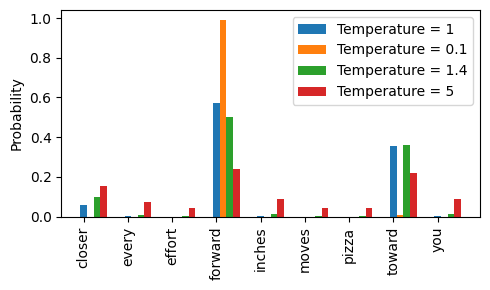

In [12]:
# Plotting
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 1.4,5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

##Multinomial
import matplotlib.pyplot as plt

x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

### TOP-K SAMPLING

In [14]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [13]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [15]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [16]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### Which Method We Will Apply In Our Code

We will use both method or we can say Combination of these 2 method

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
  for i in range(max_new_tokens):
    idx_cond=idx[:-context_size]
    with torch.no_grad():
      logits= model(idx_cond)
    logits= logits[:,-1,:]

     # New: Filter logits with top_k sampling
    if top_k is not None:
      top_logits,top_logits_index=torch.top_k(logits,top_k)
      min_val= top_logits[:,-1]
      """What happens if you don’t write .to(logits.device)?
        If your logits is on CPU → no problem, it works fine.
        If your logits is on GPU → it will throw an error because CPU and GPU tensors can’t be mixed in torch.where."""
      logits=torch.where(logits<min_val,torch.tensor(float("-inf")).to(logits.device),logits)

    if temperature >0.0:
      logits = logits/ temperature

      probas= torch.soft_max(logits,dim=-1)

      idx_next= torch.multinomial(probas,num_samples=1)
    else:
      idx_next= torch.arg_max(logits,dim=-1,keepdim=True)

    if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
          break

        # Same as before: append sampled index to the running sequence
    idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx
